In [1]:
library(ComplexHeatmap)
library(ggplot2)
library(plotly)
library(dplyr)
library(DESeq2)
library(phyloseq)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(VennDiagram)
library(ALDEx2)
library(radEmu)
library(ggpubr)
library(ggvenn)
library(pheatmap)
library(patchwork)

Loading required package: grid

ComplexHeatmap version 2.24.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:ComplexHeatmap’:

    add_heatmap


The following object is masked from ‘package:stats’:

    filter


The following objec

In [2]:
input_files <- list.files(pattern = ".*_(species|genus)\\.txt$", full.names = TRUE)

for (file in input_files) {
  # Extract file base name (e.g., 1_genus)
  file_base <- tools::file_path_sans_ext(basename(file))
  
  cat("Processing:", file_base, "\n")

  # Read input file
  source_file <- read.delim(file, header = TRUE, row.names = 1, sep = "\t")

  # Separate metadata and assay
  metadata <- source_file[, (ncol(source_file) - 1):ncol(source_file)]
  assay <- source_file[, -c((ncol(source_file) - 1):ncol(source_file))]

  # Transpose and clean assay
  assay1 <- t(assay)
  if (!all(rownames(metadata) %in% colnames(assay1))) {
    warning("Mismatch in sample names between metadata and assay:", file_base)
    next
  }

  r_a <- rownames(assay1)
  assay1 <- matrix(as.numeric(assay1), nrow = nrow(assay1))
  rownames(assay1) <- r_a
  colnames(assay1) <- rownames(metadata)
  assay1[is.na(assay1)] <- 0

  # Clean taxa names
  taxa_names <- rownames(assay1)
  taxa_cleaned <- gsub("EUPATH.*", "", taxa_names)
  rownames(assay1) <- taxa_cleaned
  taxa_split <- strsplit(taxa_cleaned, "[_.]+")

  # Fix column name and assign condition
  colnames(metadata)[colnames(metadata) == "study_condition..MBIOTEMP_study_condition."] <- "condition"
  metadata$condition <- ifelse(metadata$condition == "control", "control", "Tumor")

  # Filter low-abundance taxa
  keep <- rowSums(assay1 >= 5) >= 2
  assay1_filtered <- assay1[keep, ]

  # Assign to environment with dynamic variable names
  assign(paste0("assay_filtered_", file_base), assay1_filtered, envir = .GlobalEnv)
  assign(paste0("metadata_", file_base), metadata, envir = .GlobalEnv)

  # Optional: print variable names created
  cat("Saved variables: assay_filtered_", file_base, " and metadata_", file_base, "\n", sep = "")
}



Processing: 1_genus 
Saved variables: assay_filtered_1_genus and metadata_1_genus
Processing: 10_genus 
Saved variables: assay_filtered_10_genus and metadata_10_genus
Processing: 10_species 
Saved variables: assay_filtered_10_species and metadata_10_species
Processing: 11_genus 
Saved variables: assay_filtered_11_genus and metadata_11_genus
Processing: 11_species 
Saved variables: assay_filtered_11_species and metadata_11_species
Processing: 2_genus 
Saved variables: assay_filtered_2_genus and metadata_2_genus
Processing: 2_species 
Saved variables: assay_filtered_2_species and metadata_2_species
Processing: 3_genus 
Saved variables: assay_filtered_3_genus and metadata_3_genus
Processing: 3_species 
Saved variables: assay_filtered_3_species and metadata_3_species
Processing: 4_genus 
Saved variables: assay_filtered_4_genus and metadata_4_genus
Processing: 4_species 
Saved variables: assay_filtered_4_species and metadata_4_species
Processing: 5_genus 
Saved variables: assay_filtered_5_g

In [ ]:
# Function to create mean-variance plot from an assay matrix
create_mean_var_plot <- function(assay_data, title_label) {
  df <- assay_data %>%
    as.data.frame() %>%
    rowwise() %>%
    mutate(
      mean_counts = mean(c_across(everything())),
      variance_counts = var(c_across(everything()))
    ) %>%
    ungroup()

  ggplot(df, aes(x = mean_counts, y = variance_counts)) +
    geom_point(size = 0.5) +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    scale_x_log10() + 
    scale_y_log10() +
    theme_minimal(base_size = 10) +
    labs(
      title = title_label,
      x = "Mean Counts",
      y = "Variance Counts"
    ) +
    theme(
      plot.title = element_text(size = 10, hjust = 0.5),
      axis.title = element_text(size = 9),
      axis.text = element_text(size = 8)
    )
}

# Get all filtered assay variable names
assay_vars <- ls(pattern = "^assay_filtered_")

# Separate genus and species
genus_vars   <- assay_vars[grepl("_genus$", assay_vars)]
species_vars <- assay_vars[grepl("_species$", assay_vars)]

# Helper to extract just the suffix like "1_genus"
get_title <- function(var_name) sub("assay_filtered_", "", var_name)

# Create plots
genus_plots <- lapply(genus_vars, function(var) {
  create_mean_var_plot(get(var), get_title(var))
})

species_plots <- lapply(species_vars, function(var) {
  create_mean_var_plot(get(var), get_title(var))
})



### Mean to Variance

==== Species Plots ====


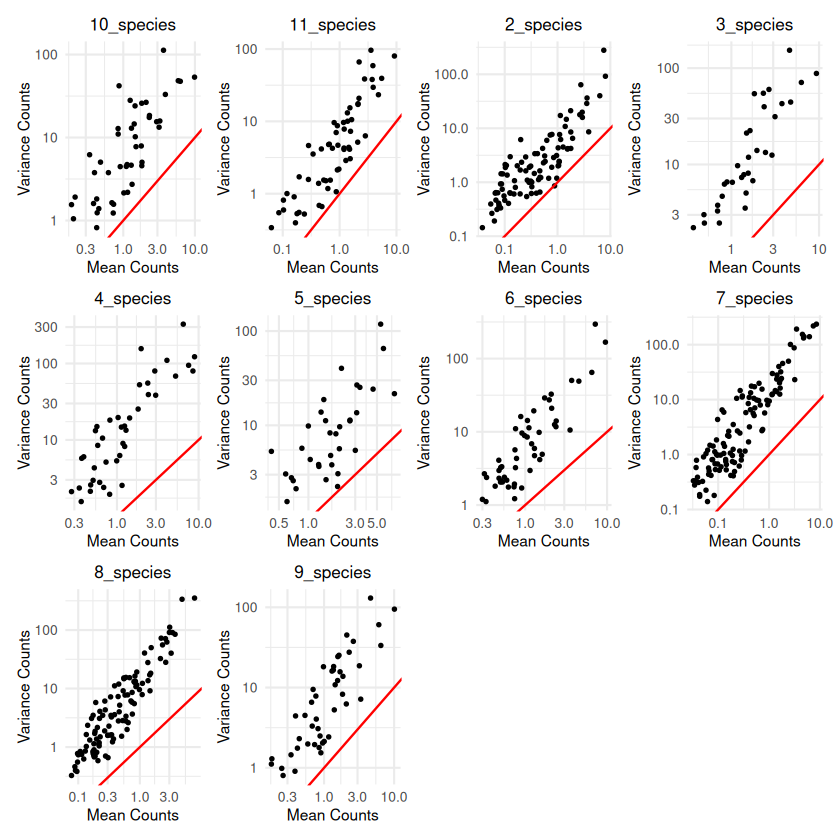

In [4]:
cat("==== Species Plots ====\n")
wrap_plots(species_plots, ncol = 4)



==== Genus Plots ====


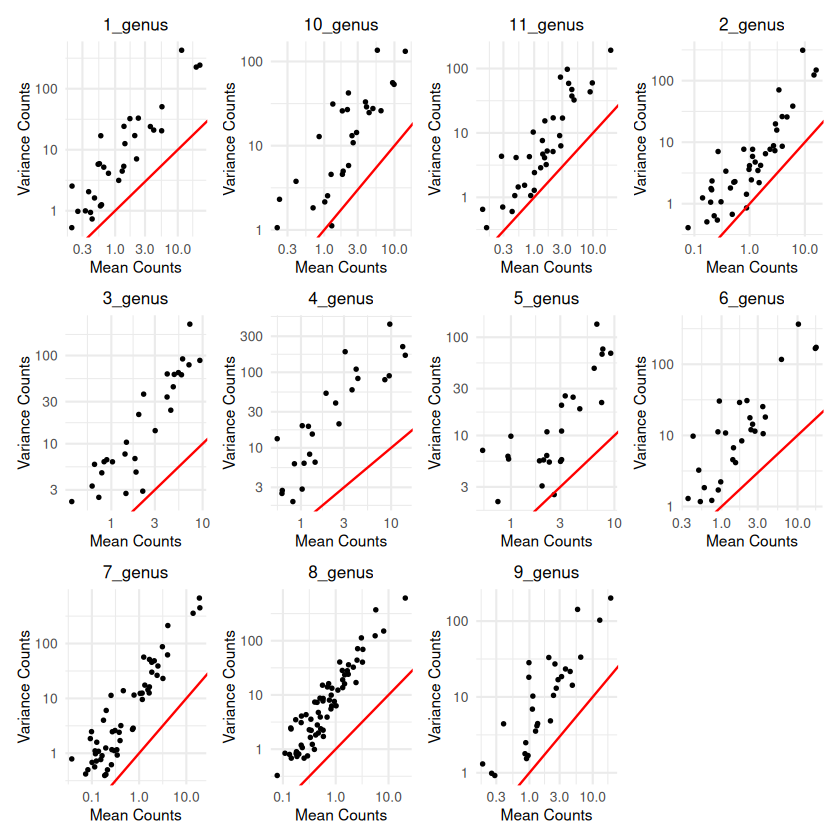

In [5]:
cat("==== Genus Plots ====\n")
wrap_plots(genus_plots, ncol = 4)


In [ ]:

# Function to generate Q-Q plot from assay
create_qq_plot <- function(assay_data, title_label) {
  assay_log <- log10(assay_data + 1)
  all_counts <- as.vector(assay_log)
  sorted_counts <- sort(all_counts)
  theoretical_quantiles <- qunif(ppoints(length(sorted_counts)))

  df <- data.frame(
    theoretical = theoretical_quantiles,
    sample = sorted_counts
  )

  ggplot(df, aes(x = theoretical, y = sample)) +
    geom_point(size = 0.5, color = "blue") +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    theme_minimal() +
    labs(title = title_label,
         x = "Theoretical Quantiles (Uniform[0,1])",
         y = "Sample Quantiles (Log10 Counts)")
}

# Get all assay variable names
assay_vars <- ls(pattern = "^assay_filtered_")

# Separate by type
genus_vars <- assay_vars[grepl("_genus$", assay_vars)]
species_vars <- assay_vars[grepl("_species$", assay_vars)]

# Create Q-Q plots
genus_qq <- lapply(genus_vars, function(var) {
  create_qq_plot(get(var), var)
})

species_qq <- lapply(species_vars, function(var) {
  create_qq_plot(get(var), var)
})


### Q-Q plot (comparison with uniform distribution)

==== Species Q-Q Plots ====


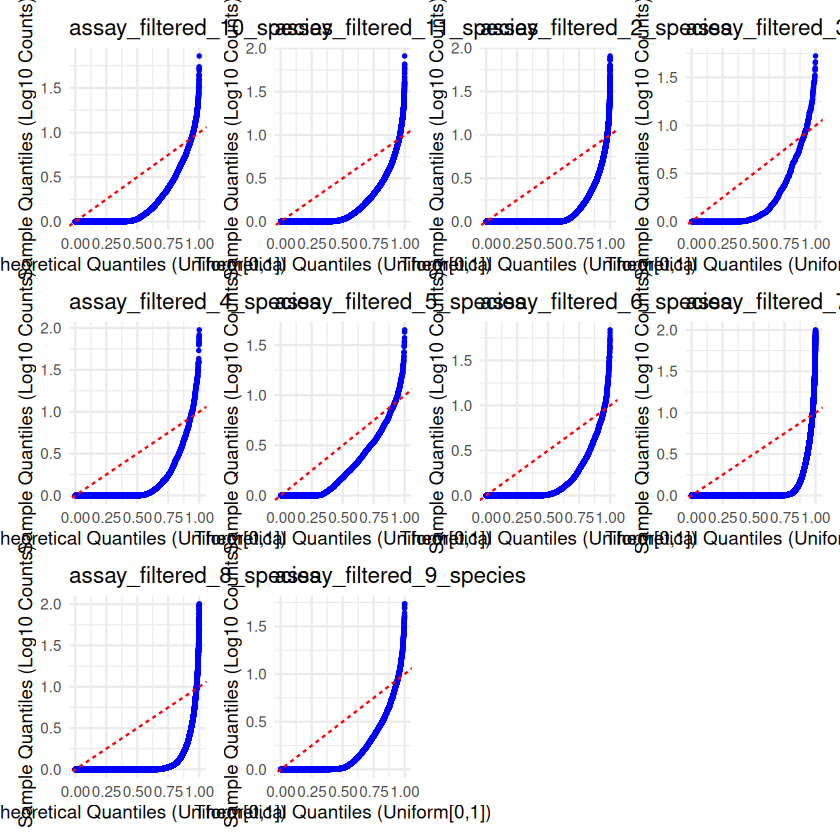

In [14]:
cat("==== Species Q-Q Plots ====\n")
wrap_plots(species_qq, ncol = 4)

==== Genus Q-Q Plots ====


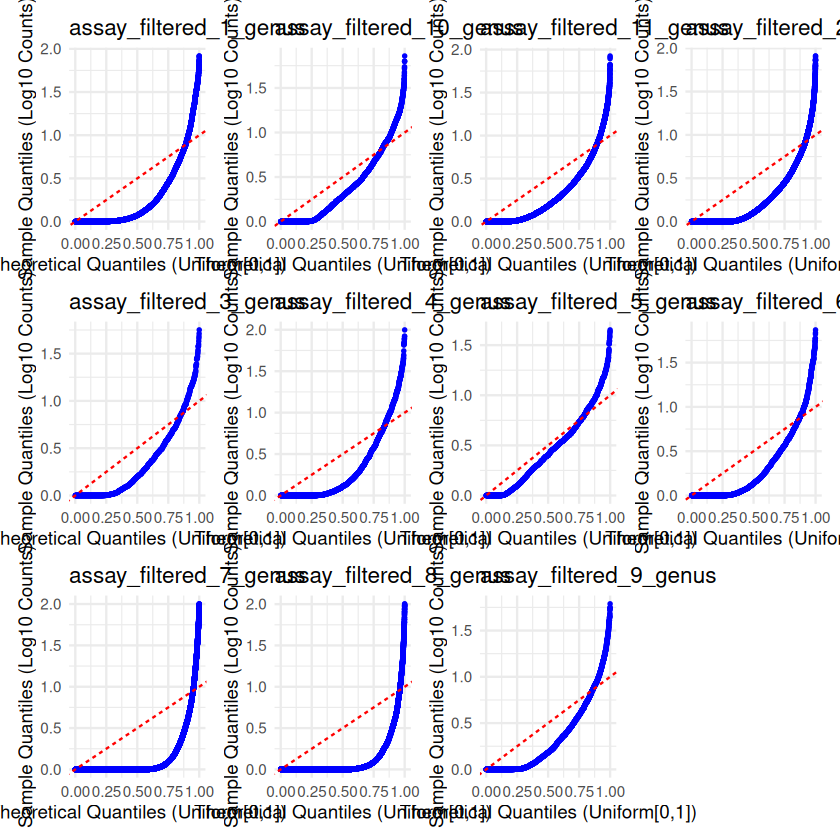

In [15]:
cat("==== Genus Q-Q Plots ====\n")
wrap_plots(genus_qq, ncol = 4)

In [ ]:
library(ggplot2)
library(patchwork)

# Helper to extract clean label from variable name
get_title <- function(var_name) sub("assay_filtered_", "", var_name)

# Function to generate Q-Q plot comparing sample counts to Poisson distribution
create_qq_plot <- function(assay_data, title_label) {
  counts <- as.vector(assay_data)
  counts <- counts[counts > 0]  # exclude zeros to avoid Poisson lambda = 0

  # Estimate lambda (mean) from data
  lambda_est <- mean(counts)

  # Sort sample counts
  sorted_counts <- sort(counts)

  # Poisson quantiles for same length using estimated lambda
  theoretical_quantiles <- qpois(ppoints(length(sorted_counts)), lambda = lambda_est)

  df <- data.frame(
    theoretical = theoretical_quantiles,
    sample = sorted_counts
  )

  ggplot(df, aes(x = theoretical, y = sample)) +
    geom_point(size = 0.5, color = "blue") +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    theme_minimal(base_size = 10) +
    labs(
      title = title_label,
      x = "Theoretical Quantiles (Poisson)",
      y = "Observed Quantiles (Raw Counts)"
    ) +
    theme(
      plot.title = element_text(size = 10, hjust = 0.5),
      axis.title = element_text(size = 9),
      axis.text = element_text(size = 8)
    )
}

# Get all assay variable names
assay_vars <- ls(pattern = "^assay_filtered_")
genus_vars <- assay_vars[grepl("_genus$", assay_vars)]
species_vars <- assay_vars[grepl("_species$", assay_vars)]

# Generate plots
genus_qq_p <- lapply(genus_vars, function(var) {
  create_qq_plot(get(var), get_title(var))
})

species_qq_p <- lapply(species_vars, function(var) {
  create_qq_plot(get(var), get_title(var))
})



### Q-Q plot for comparison with poisson distribution

==== Species Q-Q Plots ====


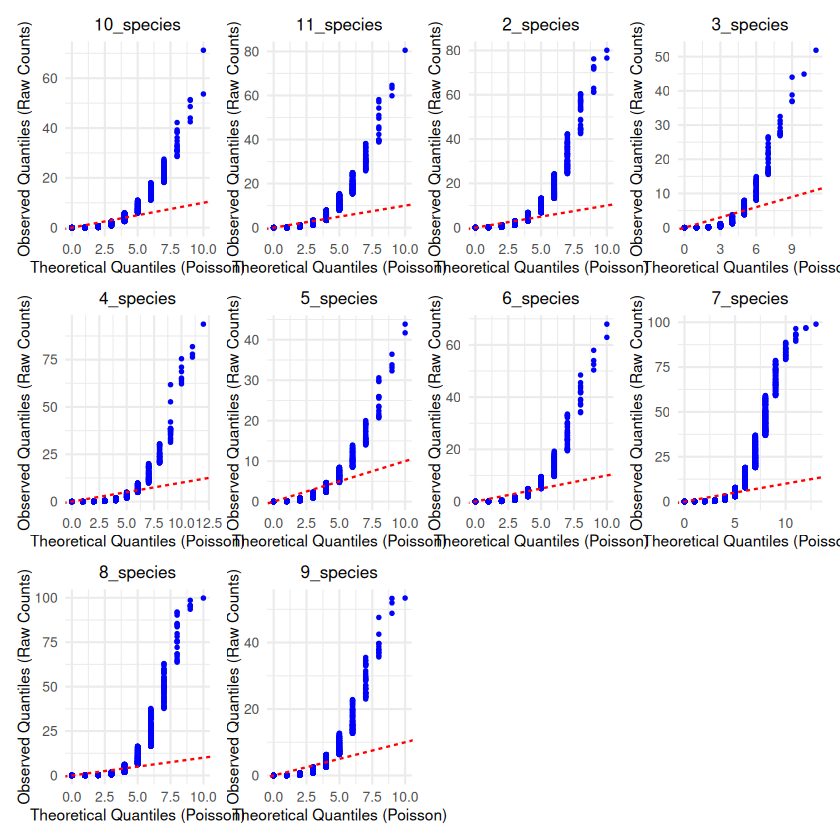

In [17]:
cat("==== Species Q-Q Plots ====\n")
wrap_plots(species_qq_p, ncol = 4)

==== Genus Q-Q Plots ====


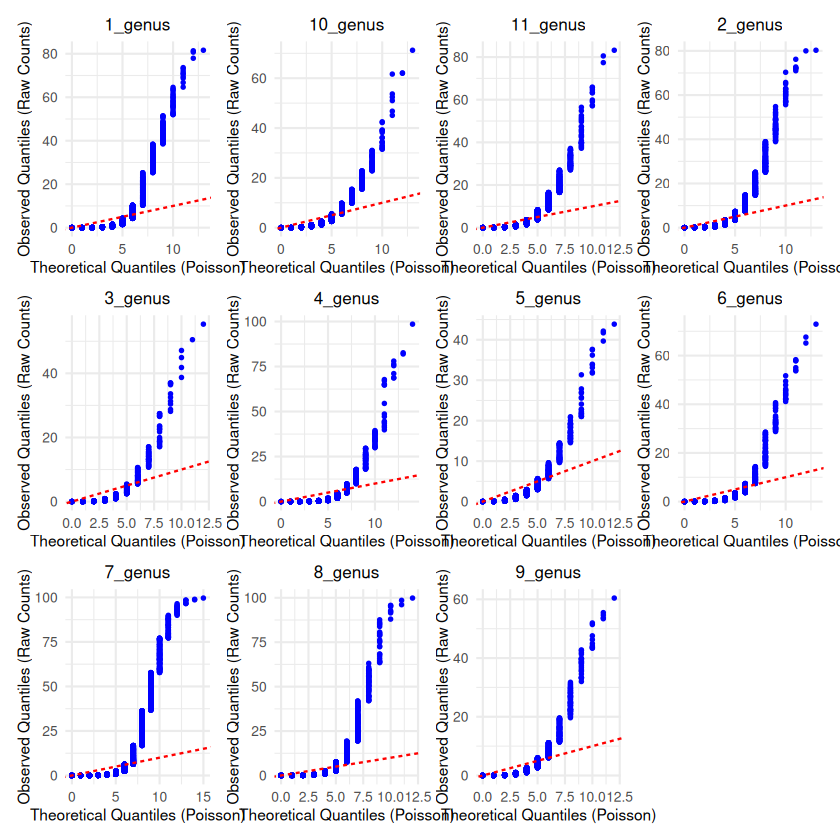

In [18]:
cat("==== Genus Q-Q Plots ====\n")
wrap_plots(genus_qq_p, ncol = 4)

In [22]:
# Set up directories
deseq_dir <- "deseq2_results"
aldex_dir <- "aldex2_results"
rademu_dir <- "rademu_results"
ancom_dir <- "ancombc_results"

# Dataset IDs
dataset_ids <- 1:11
types <- c("species", "genus")

# Threshold lists
res50_list <- list()
rad50_list <- list()
ald50_list <- list()
anc50_list <- list()

for (id in dataset_ids) {
  for (type in types) {
    suffix <- paste0(id, "_", type)

    # File paths
    deseq_file <- file.path(deseq_dir, paste0(id, "_deseq2_", type, ".csv"))
    aldex_file <- file.path(aldex_dir, paste0(id, "_aldex_results_", type, ".csv"))
    rad_file   <- file.path(rademu_dir, paste0(id, "_rademu_results", type, ".csv"))
    ancom_file <- file.path(ancom_dir, paste0(id, "_ancom_results_", type, ".csv"))

    ### DESeq2
    if (file.exists(deseq_file)) {
      resa_df <- read.csv(deseq_file, header = TRUE)
      raw_names <- make.unique(as.character(resa_df$X))
      cleaned_names <- make.unique(sub("\\.\\..*$", "", raw_names))
      rownames(resa_df) <- cleaned_names

      des_n <- nrow(resa_df)
      cutoff_des <- if (des_n < 40) 30 else if (des_n < 50) 40 else 50
      sub_resa <- head(resa_df, cutoff_des)
      res50_list[[suffix]] <- sub_resa  # full df
    }

    ### RADeMu
    if (file.exists(rad_file)) {
      rad_df <- read.csv(rad_file, header = TRUE)
      rad_df$category <- make.unique(as.character(rad_df$category))
      cleaned_names <- make.unique(sub("\\.\\..*$", "", rad_df$category))
      rownames(rad_df) <- cleaned_names

      colnames(rad_df)[colnames(rad_df) == "pval"] <- "pvalue"
      rad_n <- nrow(rad_df)
      cutoff_rad <- if (rad_n < 40) 30 else if (rad_n < 50) 40 else 50
      sub_rad <- head(rad_df, cutoff_rad)
      rad50_list[[suffix]] <- sub_rad
    }

    ### ALDEx2
    if (file.exists(aldex_file)) {
      ald_df <- read.csv(aldex_file, header = TRUE)
      raw_names <- make.unique(as.character(ald_df$X))
      cleaned_names <- make.unique(sub("\\.\\..*$", "", raw_names))
      rownames(ald_df) <- cleaned_names

      colnames(ald_df)[colnames(ald_df) == "we.ep"] <- "pvalue"
      ald_n <- nrow(ald_df)
      cutoff_ald <- if (ald_n < 40) 30 else if (ald_n < 50) 40 else 50
      sub_ald <- head(ald_df, cutoff_ald)
      ald50_list[[suffix]] <- sub_ald
    }

    ### ANCOM-BC
    if (file.exists(ancom_file)) {
      anc_df <- read.csv(ancom_file, header = TRUE)
      anc_df <- anc_df[order(anc_df[[5]]), ]
      raw_names <- make.unique(as.character(anc_df$id))
      cleaned_names <- make.unique(sub("\\.\\..*$", "", raw_names))
      rownames(anc_df) <- cleaned_names

      anc_n <- nrow(anc_df)
      cutoff_anc <- if (anc_n < 40) 30 else if (anc_n < 50) 40 else 50
      sub_anc <- head(anc_df, cutoff_anc)
      anc50_list[[suffix]] <- sub_anc
    }
  }
}
rad50_list <- list()

for (id in 1:11) {
  for (type in c("species", "genus")) {
    suffix <- paste0(id, "_", type)
    rad_file <- file.path("rademu_results", paste0(id, "_rademu_results_", type, ".csv"))

    if (file.exists(rad_file)) {
      rad_df <- read.csv(rad_file, header = TRUE)
      rad_df$category <- make.unique(as.character(rad_df$category))
      rownames(rad_df) <- make.unique(sub("\\.\\..*$", "", rad_df$category))
      colnames(rad_df)[colnames(rad_df) == "pval"] <- "pvalue"

      cutoff <- if (nrow(rad_df) < 40) 30 else if (nrow(rad_df) < 50) 40 else 50
      rad50_list[[suffix]] <- head(rad_df, cutoff)
    }
  }
}


In [23]:
library(ggvenn)
library(patchwork)
library(dplyr)

# Initialize lists to store plots and results
venn_plots <- list()
intersections_list <- list()
uniques_list <- list()

# Loop over datasets
for (id in dataset_ids) {
  for (type in types) {
    suffix <- paste0(id, "_", type)
    cat("Processing:", suffix, "\n")

    des_df <- res50_list[[suffix]]
    rad_df <- rad50_list[[suffix]]
    ald_df <- ald50_list[[suffix]]
    anc_df <- anc50_list[[suffix]]

    # Debug validation
    if (!is.data.frame(des_df)) cat(" - des_df is not a data.frame\n")
    if (!is.data.frame(rad_df)) cat(" - rad_df is not a data.frame\n")
    if (!is.data.frame(ald_df)) cat(" - ald_df is not a data.frame\n")
    if (!is.data.frame(anc_df)) cat(" - anc_df is not a data.frame\n")

    # Skip invalid
    if (!is.data.frame(des_df) || !is.data.frame(rad_df) ||
        !is.data.frame(ald_df) || !is.data.frame(anc_df)) {
      next
    }

    # Extract rownames
    des50 <- rownames(des_df)
    rad50 <- rownames(rad_df)
    ald50 <- rownames(ald_df)
    anc50 <- rownames(anc_df)

    # Create union of all taxa
    all_taxa <- unique(c(des50, rad50, ald50, anc50))

    # Presence matrix
    presence_df <- data.frame(
      taxa = all_taxa,
      DESeq2  = all_taxa %in% des50,
      RADeMu  = all_taxa %in% rad50,
      ALDEx2  = all_taxa %in% ald50,
      ANCOMBC = all_taxa %in% anc50
    )

    # Make binary
    presence_df[,-1] <- lapply(presence_df[,-1], as.integer)

    # Create Venn list
    venn_list <- list(
      DESeq2 = presence_df$taxa[presence_df$DESeq2 == 1],
      RADeMu = presence_df$taxa[presence_df$RADeMu == 1],
      ALDEx2 = presence_df$taxa[presence_df$ALDEx2 == 1],
      ANCOMBC = presence_df$taxa[presence_df$ANCOMBC == 1]
    )

    # Create Venn plot
  p <- ggvenn(
  venn_list,
  fill_color = c("blue", "red", "green", "purple"),
  stroke_size = 0.6,
  text_size = 3,
  set_name_size = 0   # ⬅️ This hides DESeq2 / RADeMu etc. labels
)


    venn_plots[[suffix]] <- p

    # Intersections
    intersections_list[[suffix]] <- list(
      intersect_all = Reduce(intersect, venn_list),
      intersect_DESeq2_RADeMu = intersect(venn_list$DESeq2, venn_list$RADeMu),
      intersect_DESeq2_ALDEx2 = intersect(venn_list$DESeq2, venn_list$ALDEx2),
      intersect_DESeq2_ANCOMBC = intersect(venn_list$DESeq2, venn_list$ANCOMBC)
    )

    # Unique sets
    all_other <- function(x, lst) unlist(lst[names(lst) != x])

    uniques_list[[suffix]] <- list(
      DESeq2_only  = setdiff(venn_list$DESeq2, all_other("DESeq2", venn_list)),
      RADeMu_only  = setdiff(venn_list$RADeMu, all_other("RADeMu", venn_list)),
      ALDEx2_only  = setdiff(venn_list$ALDEx2, all_other("ALDEx2", venn_list)),
      ANCOMBC_only = setdiff(venn_list$ANCOMBC, all_other("ANCOMBC", venn_list))
    )
    
  }
}
# Remove NULL entries (skipped datasets)
venn_plots_clean <- Filter(Negate(is.null), venn_plots)

# Separate species and genus plots
species_plots <- venn_plots_clean[grepl("_species$", names(venn_plots_clean))]
genus_plots   <- venn_plots_clean[grepl("_genus$", names(venn_plots_clean))]

Processing: 1_species 
Processing: 1_genus 
Processing: 2_species 
Processing: 2_genus 
Processing: 3_species 
Processing: 3_genus 
Processing: 4_species 
Processing: 4_genus 
Processing: 5_species 
Processing: 5_genus 
Processing: 6_species 
Processing: 6_genus 
Processing: 7_species 
Processing: 7_genus 
Processing: 8_species 
Processing: 8_genus 
Processing: 9_species 
Processing: 9_genus 
Processing: 10_species 
Processing: 10_genus 
Processing: 11_species 
Processing: 11_genus 


In [24]:


dir.create("intersected_taxa", showWarnings = FALSE)
dir.create("unique_taxa", showWarnings = FALSE)

for (suffix in names(intersections_list)) {
  inter <- intersections_list[[suffix]]
  for (name in names(inter)) {
    write.csv(data.frame(taxa = inter[[name]]),
              file = file.path("intersected_taxa", paste0(suffix, "_", name, ".csv")),
              row.names = FALSE)
  }

  uniq <- uniques_list[[suffix]]
  for (name in names(uniq)) {
    write.csv(data.frame(taxa = uniq[[name]]),
              file = file.path("unique_taxa", paste0(suffix, "_", name, ".csv")),
              row.names = FALSE)
  }
}

In [25]:
summary_list <- list()

# Loop through all dataset suffixes
for (suffix in names(intersections_list)) {
  inter <- intersections_list[[suffix]]
  uniq  <- uniques_list[[suffix]]

  summary_list[[suffix]] <- data.frame(
    dataset = suffix,
    n_intersect_all     = length(inter$intersect_all),
    n_unique_DESeq2     = length(uniq$DESeq2_only),
    n_unique_RADeMu     = length(uniq$RADeMu_only),
    n_unique_ALDEx2     = length(uniq$ALDEx2_only),
    n_unique_ANCOMBC    = length(uniq$ANCOMBC_only)
  )
}

# Combine into one big data frame
summary_df <- do.call(rbind, summary_list)
rownames(summary_df) <- NULL

# Preview
head(summary_df)
#write.csv(summary_df, file = "summary_intersected_unique.csv")


,dataset,n_intersect_all,n_unique_DESeq2,n_unique_RADeMu,n_unique_ALDEx2,n_unique_ANCOMBC
,<chr>,<int>,<int>,<int>,<int>,<int>
1,1_species,29,0,6,2,11
2,1_genus,23,0,1,0,1
3,2_species,27,4,4,5,12
4,2_genus,25,0,0,3,3
5,3_species,30,0,0,0,0
6,3_genus,16,0,0,0,4


In [26]:
library(ggplot2)
library(patchwork)

# Define method-color mapping
method_colors <- c("DESeq2" = "blue", "radEmu" = "red", "ALDEx2" = "green", "ANCOMBC" = "purple")

# Create side legend
legend_plot <- ggplot(data.frame(method = names(method_colors)), aes(x = 1, y = method, fill = method)) +
  geom_tile(height = 0.9) +
  geom_text(aes(label = method), color = "white", size = 4.5, hjust = 0.5) +
  scale_fill_manual(values = method_colors) +
  theme_void() +
  theme(
    plot.title = element_text(size = 11, face = "bold"),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  ggtitle("Methods")

# Clean titles of all species/genus plots
species_plots <- lapply(names(species_plots), function(name) {
  species_plots[[name]] + ggtitle(name) +
    theme(plot.title = element_text(size = 10, hjust = 0.5, face = "bold"))
})

genus_plots <- lapply(names(genus_plots), function(name) {
  genus_plots[[name]] + ggtitle(name) +
    theme(plot.title = element_text(size = 10, hjust = 0.5, face = "bold"))
})

# Combine into grids
species_grid <- wrap_plots(species_plots, ncol = 4)
genus_grid   <- wrap_plots(genus_plots, ncol = 4)

# Add the side legend
species_final <- legend_plot + species_grid + plot_layout(ncol = 2, widths = c(1.2, 5))
genus_final   <- legend_plot + genus_grid + plot_layout(ncol = 2, widths = c(1.2, 5))




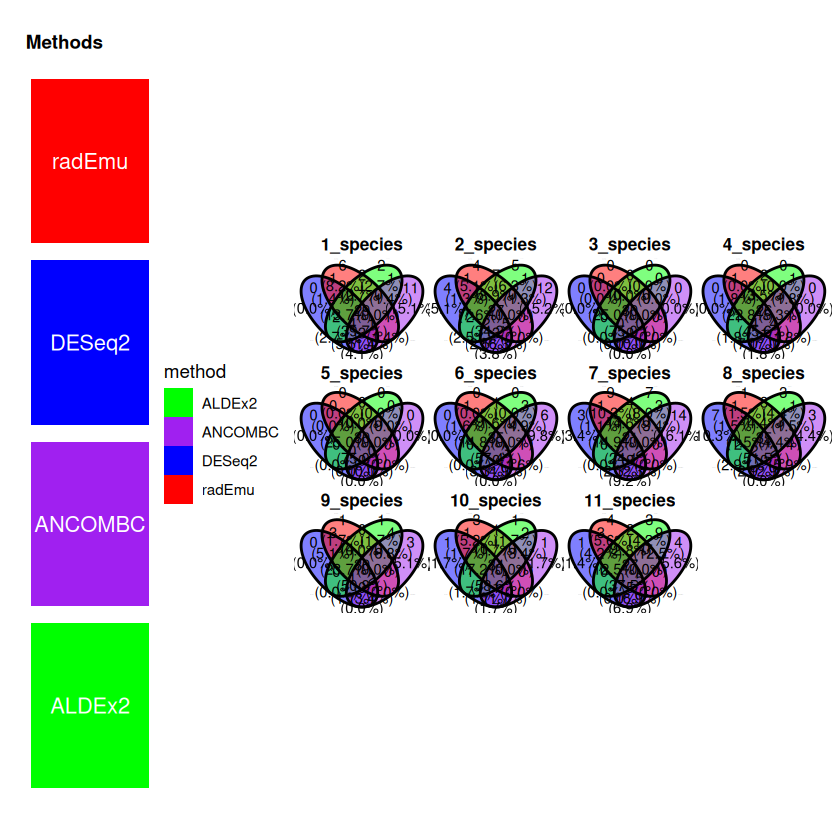

In [27]:
species_final

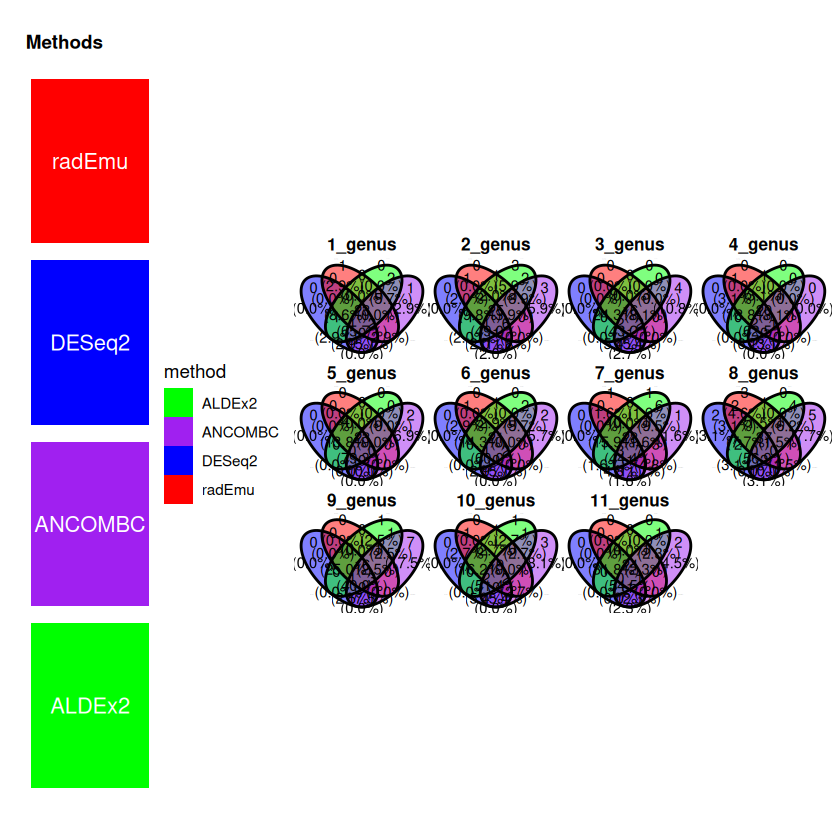

In [28]:
genus_final